# Classification Analysis

In [25]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from xgboost import XGBClassifier

def fb_score(y_true, y_pred, beta):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return ((1 + beta**2) * precision * recall) / ((beta**2) * precision + recall)

def f1_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall)

def f2_func(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return (5 * precision * recall) / (4 * precision + recall)

def classification_results(y_true, y_pred, verbose=0):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_func(y_true, y_pred)
    f2 = f2_func(y_true, y_pred)
    if verbose:
        results = [
            ("accuracy", accuracy), 
            ("precision", precision),
            ("recall", recall),
            ("f1", f1),
            ("f2", f2),
        ]
        print("\nCLASSIFICATION METRICS:\n")
        for (metric, score) in results:
            print(f"{metric} = {score:.2f}")
        print("\n")
    else:
        results = np.array([accuracy, precision, recall, f1, f2])
    return results

f1_score = make_scorer(f1_func)
f2_score = make_scorer(f2_func)

base_dir = os.path.join(os.getcwd(), os.pardir)

## Feature sets

Because a lot of the features in the dataset are highly correlated with eachother it makes sense to create some feature-sets so we can make analysis with or without certain groups of features.

As we are looking to see if increased screen time leads to poorer mental health, it does not make sense to make clasifications of `has_dep_diag` from all the features as this includes features such as `dep_score`, `dep_band`, `dep_thoughts` etc. which will contribute to the classification far more than screen time related features such as `comp_house` and `comp_games`.

We shall create feature sets for:

- __all__ features
- __non-medical__ features (depression, anxiety etc.)
- __only screen time__ features

In [57]:
target_feature = ["has_dep_diag"]
drop_features = ["prim_diag", "secd_diag"]

medical_features = [
    "mat_dep","mat_anx_1", "mat_anx_18m", 
    "mat_anx_8m", "agg_score", "emot_cruel", 
    "phys_cruel", "mat_anx_0m", "dep_band_15", 
    "dep_band_13", "dep_band_10", "dep_band_07", 
    "anx_band_15", "anx_band_13", "anx_band_10", 
    "anx_band_07", "secd_diag","prim_diag", 
    "panic_score", "dep_thoughts", "dep_score", 
]

# [feature for feature in all_features if not feature in medical_features]
non_medical_features = [
    "comp_bed_9", "mat_age", "weight_16", "height_16", "iq",
    "comp_noint_bed_16", "comp_int_bed_16", "talk_phon_wend", 
    "text_wend", "talk_mob_wend", "comp_wend", "musi_wend", 
    "read_wend", "work_wend", "alon_wend", "draw_wend", 
    "play_wend", "tv_wend", "out_win_wend", "out_sum_wend", 
    "tran_wend", "talk_phon_week", "text_week", "talk_mob_week", 
    "comp_week", "musi_week", "read_week", "work_week", 
    "alon_week", "draw_week", "play_week", "tv_week", 
    "out_win_week", "out_sum_week", "tran_week", "pat_pres_10",
    "pat_pres_8", "pat_pres", "num_home", "pat_ses", "mat_ses", 
    "pat_edu", "mat_edu", "parity", "exercise", "child_bull", 
    "phone_14_wend", "phone_14_week", "musi_13", "tv_bed_9", 
    "own_mob", "comp_house", "tv_bed_16", "creat_14", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor", "sex", "birth_order"
]

screen_time_features = [
    "comp_bed_9", "comp_noint_bed_16", 
    "comp_int_bed_16", "comp_wend", "tv_wend",
    "comp_week", "tv_week", "tv_bed_9", 
    "comp_house", "tv_bed_16", "comp_games", 
    "fam_tv_eve", "fam_tv_aft", "fam_tv_mor",
]

fset_cols = [all_features, non_medical_features, screen_time_features]

`note: we consider 'screen time' to be features relating to either a computer or TV.`

We can now create the reduced training and testing sets.

In [58]:
# data_path = os.path.join(base_dir, "data/altered/imputed/maps_xgboost_impute.csv")
# df = pd.read_csv(data_path, index_col="X")

# X = df.drop(["has_dep_diag", "prim_diag", "secd_diag"], axis=1)
# y = df["has_dep_diag"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

train_path = os.path.join(base_dir, "data/classification/train.csv")
test_path = os.path.join(base_dir, "data/classification/test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

X_train, X_test = train_df.copy().drop(target_feature, axis=1), test_df.copy().drop(target_feature, axis=1)
y_train, y_test = train_df[target_feature], test_df[target_feature]

X_train_all = X_train.copy().drop(drop_features, axis=1)
X_test_all = X_test.copy().drop(drop_features, axis=1)

X_train_non_medical = X_train.copy()[non_medical_features]
X_test_non_medical = X_test.copy()[non_medical_features]

X_train_screen_time = X_train.copy()[screen_time_features]
X_test_screen_time = X_test.copy()[screen_time_features]

fsets = [
    ("all features", X_train_all, X_test_all),
    ("non medical features", X_train_non_medical, X_test_non_medical),
    ("screen time features", X_train_screen_time, X_test_screen_time),
]

## Class balance

We wish to perform classification on the feature `has_dep_diag`. Our evaluation metric of choice will depend on the balance of positive and negative samples. Let's look at the count of each.

minority:majority = 310:10677 (1:34)


<AxesSubplot:xlabel='class', ylabel='count'>

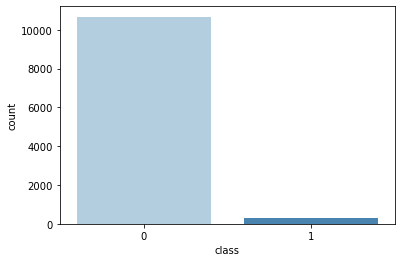

In [63]:
dep_counts = y_train.value_counts()
dep_list = list(zip([0, 1], dep_counts.tolist()))
sample_ratio = dep_counts[0] / dep_counts[1]
print(f"minority:majority = {dep_counts[1]}:{dep_counts[0]} (1:{sample_ratio:.0f})")

dep_df = pd.DataFrame(dep_list, columns=["class", "count"])
sns.barplot(x="class", y="count", data=dep_df, palette="Blues")

As you can see the distribution of values in this feature is massively uneven.

This is not ideal from a classification perspective, but we wouldn't really want half of the children in the study to be depressed!

This ratio as this be useful later; we call the positive class (1) the minority class and the negative class (0) the majority class.

## Metrics for imbalanced classification

When analysing the performance of classification on the imputated data we used F1-score as our target metric. We did so as we suspected we would have imbalanced classes and so standard accuracy would not perform well. F1-score is the harmonic mean of precision and recall, so maximising the F1-score results in a classifier sensitive to both true positives and false negatives.

F1-score is an instance of the more general metric F-score, or Fβ. The equation for Fβ is as follows:

```
Fβ = ((1 + β^2) * precision * recall) / ((β**2) * precision + recall)
```

With F1 we have:

```
F1 = ((1 + 1) * precision * recall) / (1 * precision + recall)
F1 = (2 * precision * recall) / precision + recall)
```

It then follows that the F2 score would be: 

```
F2 = (1 + 4) * precision * recall) / ((4) * precision + recall)
F2 = (5 * precision * recall) / (4 * precision + recall)
```

This results in a metric which weights recall higher than precision. What this means is we have a metric that is sensitive to false negatives.

False negative sensitivity is of particular interest to us as we would rather air on the side of caution and mis-classify someone as having depression and them receive treatment than classify someone who didn't as being ok. For this reason we shall use the F2 score as our target metric for further classification analysis.

`metrics defined during import (at the top)`

## Classification optimisation

Our previous classifier was not optimal. We shall run a randomised hyper-parameter search to find a better classifier.

First lets create the base classifier.

In [37]:
xgb = XGBClassifier(
	objective="binary:logistic",
    eval_metric="logloss",
	scale_pos_weight=sample_ratio,
	n_jobs=1,
)

`Note: we have used the sample ratio to tell XGBoost to weight the positive and negative samples correctly.`

Let's specify the search parameters.

In [239]:
params = {
	"n_estimators": [200, 500, 1000],
	"max_depth": [3, 5, 10],
	"gamma": [0.5, 1, 2],
	"min_child_weight": [1, 5, 10],
	"subsample": [0.5, 0.75, 1],
	"colsample_bytree": [0.5, 0.75, 1],
}

Now we can perform a search of 500 parameter permutations with 3-fold cross-validation.

In [253]:
rsearch = RandomizedSearchCV(xgb, params, scoring=f2_score, n_iter=500, cv=3, n_jobs=-1)

Now we can run the parameter search.

As we discovered during imputation analysis, classification with all features yields results nearing 100% accuracy (and 1.0 F1-score). 

This will make it difficult to compare parameter due to perfect accuracy being easily obtainable. It makes sense to use the most reduced feature set as the increased difficulty of the classification task will require more precise parameter choices. As the screen time features are the target of our main analysis it also makes sense to optimse our classifier for this task.

In [254]:
rsearch.fit(X_train_screen_time, y_train)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=...
                                           reg_lambda=None,
                                           scale_pos_weight=10.58904109589041,
                                          

^ `this takes a while` ^

In [308]:
preds = rsearch.best_estimator_.predict(X_test_screen_time)
classification_results(y_test, preds, verbose=1)


CLASSIFICATION METRICS:

accuracy = 0.62
precision = 0.08
recall = 0.34
f1 = 0.13
f2 = 0.21




[('accuracy', 0.6182462356067316),
 ('precision', 0.0825),
 ('recall', 0.3402061855670103),
 ('f1', 0.13279678068410464),
 ('f2', 0.20939086294416248)]

Now we can look at the best parameters.

In [256]:
rsearch.best_params_

{'subsample': 0.75,
 'n_estimators': 200,
 'min_child_weight': 10,
 'max_depth': 3,
 'gamma': 2,
 'colsample_bytree': 0.5}

`Note: as we used a random parameter search this is likely not the best results, but due to the time-complexity of using a grid search (or further exploring hyperparameters) with this parameter set this shall suffice.`

Based on these results we can manually test some parameters to get a fine-tuned results.

In [8]:
xgb = XGBClassifier(
	objective="binary:logistic",
    eval_metric="logloss",
	scale_pos_weight=sample_ratio,
    subsample=1,
    n_estimators=500,
    min_child_weight=10,
    max_depth=3,
    gamma=1,
    colsample_bytree=1,
    n_jobs=-1,
)

xgb.fit(X_train_screen_time, y_train)
preds = xgb.predict(X_test_screen_time)
results = classification_results(y_test, preds, verbose=1)

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

CLASSIFICATION METRICS:

accuracy = 0.65
precision = 0.10
recall = 0.40
f1 = 0.16
f2 = 0.25




We have managed to gain an extra 0.04 F2! Let's compare this to the base XGBoost classifier to check we made some improvement.

In [9]:
clf = XGBClassifier(
	objective="binary:logistic",
    eval_metric="logloss",
	scale_pos_weight=sample_ratio,
	n_jobs=-1,
)

clf.fit(X_train_screen_time, y_train)
preds = clf.predict(X_test_screen_time)

clf_results = classification_results(y_test, preds, verbose=1)


CLASSIFICATION METRICS:

accuracy = 0.75
precision = 0.09
recall = 0.20
f1 = 0.12
f2 = 0.16


/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy may have reduced, but as explained previously this is somewhat meaningless when we have unabalanced classes.

The important metric here is F2 score and this increased from `0.16` to `0.25`. Other metrics have seen a noticable increase too.

## Classification on feature sets

We shall perform classification on each of the feature sets.

In [64]:
fset_results = []

for (fset, fset_X_train, fset_X_test) in fsets:
    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        # scale_pos_weight=sample_ratio,
        # subsample=1,
        # n_estimators=500,
        # min_child_weight=10,
        # max_depth=3,
        # gamma=1,
        # colsample_bytree=1,
        n_jobs=-1,
    )
    xgb.fit(fset_X_train, y_train)
    preds = xgb.predict(fset_X_test)
    results = classification_results(y_test, preds)
    fset_results.append((fset, xgb, results))

/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/kai/anaconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Classification results of each feature set.

In [65]:
columns = ["Accuracy", "Precision", "Recall", "F1-Score", "F2-Score"]
idxs = ["All", "Non-Medical", "Screen Time"]
pd.DataFrame([[x for x in xs] for xs in np.array(fset_results)[:,2]], columns=columns, index=idxs)

,Accuracy,Precision,Recall,F1-Score,F2-Score
All,0.991141,0.971014,0.917808,0.943662,0.927978
Non-Medical,0.965670,0.956522,0.602740,0.739496,0.650888
Screen Time,0.935770,0.941176,0.219178,0.355556,0.258900


## Feature Importances

Importances of each feature set.

In [82]:
cols = ["Feature", "Importance", "Feature Set"]
importance_df = pd.DataFrame(columns=cols)
fset_cols = [fset[1].columns for fset in fsets]

for (features, (fset, fset_xgb, fset_result)) in zip(fset_cols, fset_results):
    imps = fset_xgb.feature_importances_
    for (feature, imp) in zip(features, imps):
        importance_df = importance_df.append(pd.DataFrame([[feature, imp, fset]], columns=cols))

importance_df

,Feature,Importance,Feature Set
0,comp_bed_9,0.014118,all features
0,mat_dep,0.010877,all features
0,mat_age,0.011512,all features
0,weight_16,0.014280,all features
0,height_16,0.009446,all features
...,...,...,...
0,tv_bed_16,0.110528,screen time features
0,comp_games,0.074505,screen time features
0,fam_tv_eve,0.070899,screen time features
0,fam_tv_aft,0.068412,screen time features


All features importance.

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from All non-Diagnosis Features'}, xlabel='Feature', ylabel='Importance'>

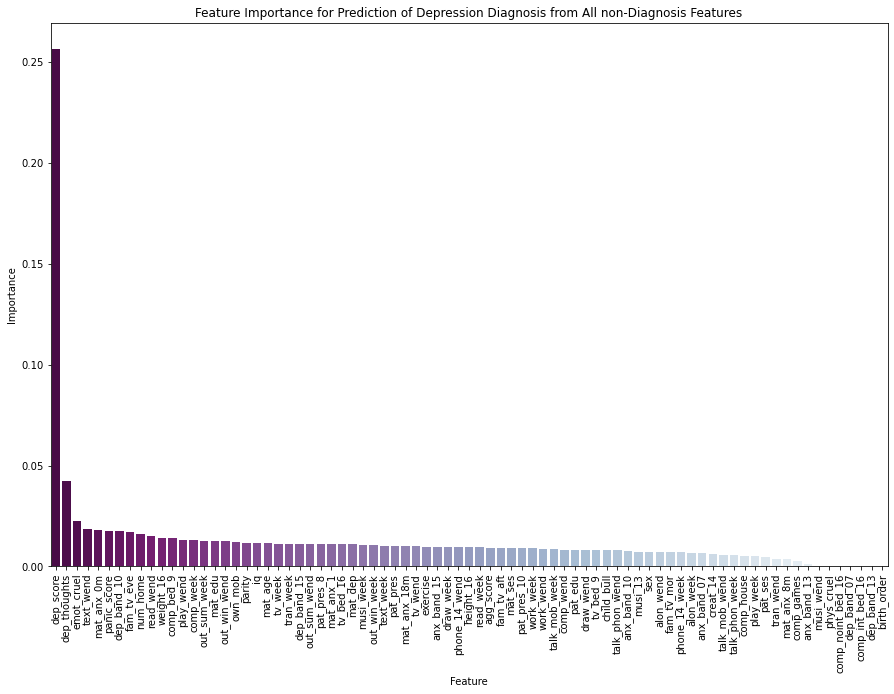

In [91]:
all_imp_df = importance_df[importance_df["Feature Set"] == "all features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from All non-Diagnosis Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=all_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")

As we can see above the target feature `has_dep_diag` can be fully explained by the feature `prim_diag`. That is, if they have a depression diagnosis, then their primary depression diagnosis will also be positive. This makes sense and enforces our reasoning of classifying with a reduced feature set.

Lets look at the feature importances when we remove medical features.

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from Non-Medical Features'}, xlabel='Feature', ylabel='Importance'>

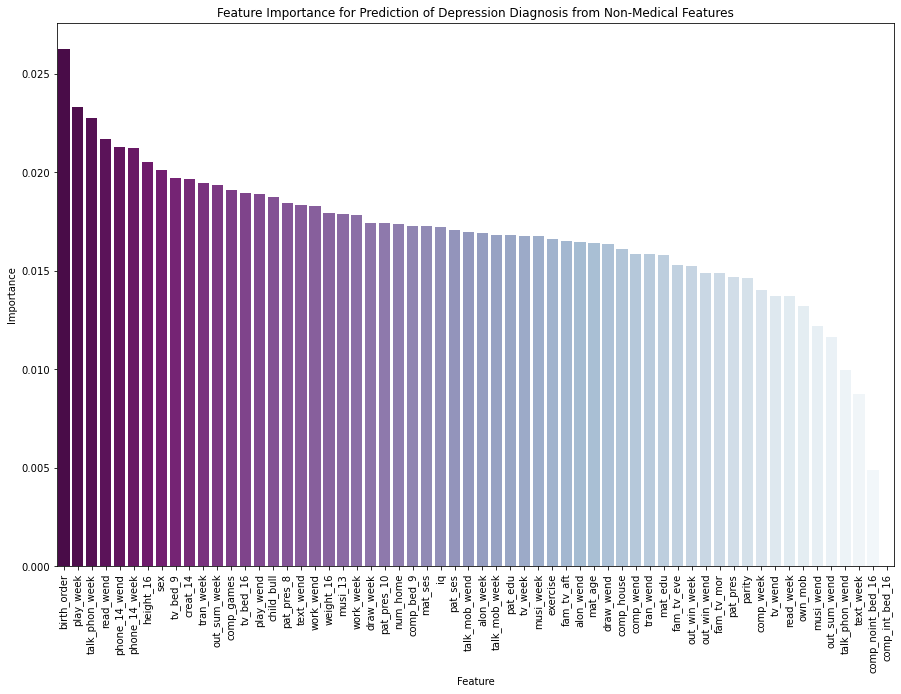

In [89]:
nonmed_imp_df = importance_df[importance_df["Feature Set"] == "non medical features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from Non-Medical Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=nonmed_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")

<AxesSubplot:title={'center':'Feature Importance for Prediction of Depression Diagnosis from Screen Time Features'}, xlabel='Feature', ylabel='Importance'>

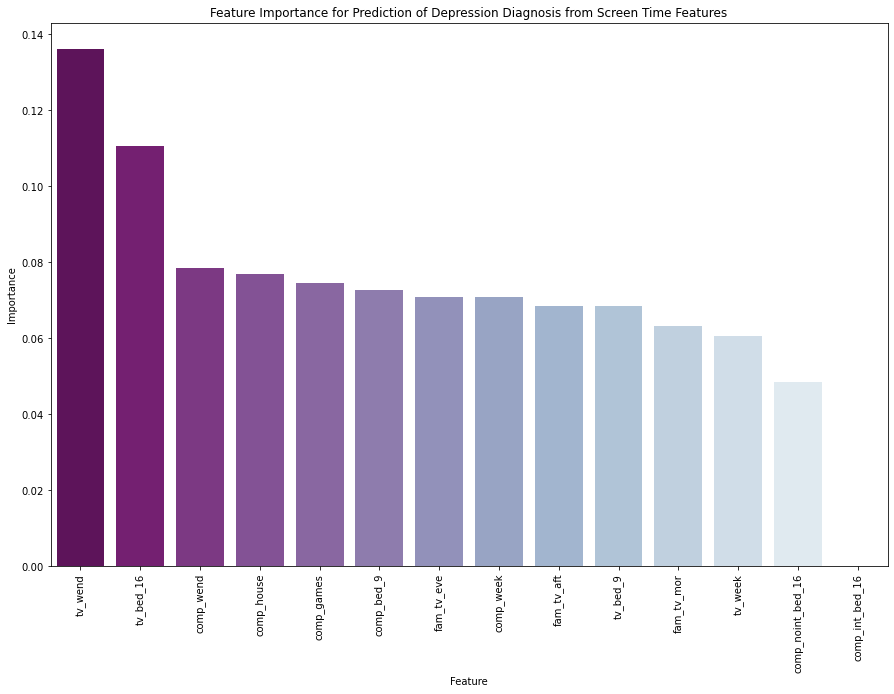

In [88]:
screentime_imp_df = importance_df[importance_df["Feature Set"] == "screen time features"]

fig = plt.figure(figsize=(15,10))
plt.title("Feature Importance for Prediction of Depression Diagnosis from Screen Time Features")
plt.xticks(rotation=90)
sns.barplot(x='Feature', y='Importance', data=screentime_imp_df.sort_values("Importance", ascending=False), palette="BuPu_r")